In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx
import uuid
import itertools
import copy
import math
import time
from PIL import Image
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Useful functions

In [3]:
def als_solve(A, B):
    return torch.linalg.lstsq(A, B).solution
def unfold(tensor, mode):
    """
    Unfolds an n-th order tensor along the specified mode.
    
    Args:
        tensor (torch.Tensor): Input tensor of shape (d0, d1, ..., dn)
        mode (int): Mode along which to unfold (0-based)
        
    Returns:
        torch.Tensor: The mode-i unfolding of shape (tensor.size(mode), -1)
    """
    # Move the mode to the first dimension
    new_order = [mode] + [i for i in range(tensor.ndim) if i != mode]
    permuted = tensor.permute(new_order)
    
    # Flatten all dimensions except the first (which is mode)
    unfolded = permuted.reshape(tensor.shape[mode], -1)
    return unfolded
def fold(unfolded, mode, shape):
    """
    Refolds a matrix back into a tensor of given shape along a mode.
    
    Args:
        unfolded (torch.Tensor): Unfolded matrix of shape (shape[mode], -1)
        mode (int): Mode along which it was unfolded (0-based)
        shape (tuple): Original shape of the tensor before unfolding
        
    Returns:
        torch.Tensor: The refolded tensor of shape `shape`
    """
    # Calculate the shape after permuting mode to front
    new_order = [mode] + [i for i in range(len(shape)) if i != mode]
    inverse_order = list(torch.argsort(torch.tensor(new_order)))

    # Compute the shape of the permuted tensor
    permuted_shape = (shape[mode], -1)
    reshaped = unfolded.reshape([shape[mode]] + [shape[i] for i in range(len(shape)) if i != mode])

    # Invert the permutation to get original order
    folded = reshaped.permute(*inverse_order)
    return folded
def unfold_to_matrix(x: torch.Tensor, dims_to_rows: list[int]) -> torch.Tensor:
    """
    Unfolds a tensor into a matrix, flattening `dims_to_rows` into rows,
    and the rest into columns.

    Args:
        x (torch.Tensor): The input tensor.
        dims_to_rows (list[int]): Dimensions to flatten into the row axis.

    Returns:
        torch.Tensor: A 2D tensor (matrix) of shape (prod(dims_to_rows), prod(other_dims)).
    """
    all_dims = list(range(x.ndim))
    dims_to_cols = [d for d in all_dims if d not in dims_to_rows]

    # Permute to bring row dims first, then col dims
    permuted_dims = dims_to_rows + dims_to_cols
    x_permuted = x.permute(permuted_dims)

    # Compute new shape
    row_size = int(torch.prod(torch.tensor([x.shape[d] for d in dims_to_rows])))
    col_size = int(torch.prod(torch.tensor([x.shape[d] for d in dims_to_cols])))

    return x_permuted.reshape(row_size, col_size)
def get_inverse_perm(p):
    r = []
    for i in range(len(p)):
        # Busquem i en p, la seva pos s'afegeix a r
        for j in range(len(p)):
            if p[j] == i:
                r.append(j)
                break
    return r
def find_permutation(X, Y):
    """
    Returns a list of indices such that applying this permutation to X results in Y.
    Works with unhashable elements.
    """
    if len(X) != len(Y):
        raise ValueError("X and Y must be of the same length.")

    used = [False] * len(Y)
    permutation = []

    for x in X:
        found = False
        for i, y in enumerate(Y):
            if not used[i] and x == y:
                permutation.append(i)
                used[i] = True
                found = True
                break
        if not found:
            raise ValueError("Y is not a permutation of X.")

    return permutation

# TN Class

In [4]:
class TN():
    def initTensor(self, shape):
        return torch.randn(shape, device=device)
    def __init__(self, G, sizes, ranks):
        if len(G.edges) != len(ranks):
            raise Exception("Rank length must be equal to the number of edges")
        if len(G.nodes) != len(sizes):
            raise Exception("Sizes length must be equal to the number of nodes")
        self.data = {}
        self.tensors = {}
        # Init data
        i = 0
        for node in G.nodes:
            self.data[node] = [ [sizes[i], -1, i] ]
            i += 1
        i = 0
        for e in G.edges:
            node1, node2 = (e[0], e[1])
            h = uuid.uuid4()
            self.data[node1] += [  [ranks[i], h] ]
            self.data[node2] += [  [ranks[i], h]  ]
            i += 1
        i = 0
        for node in G.nodes:
            shape = []
            for x in self.data[node]:
                shape.append(x[0])
            self.tensors[node] = self.initTensor(shape)
            i += 1
        # print(self.data)
        # print(self.tensors)
    def set_core(self, tensor, node):
        self.tensors[node] = tensor
    def get_core(self, node):
        return self.tensors[node]
    def get_tn_size(self):
        s = 0
        for k in self.tensors.keys():
            s += torch.numel(self.tensors[k])
        return s
    def contract(self, node1, node2, newnode):
        # Compute other indexes
        dim1 = []
        dim2 = []
        for i in range(len(self.data[node1])):
            for j in range(len(self.data[node2])):
                if self.data[node1][i][1] == -1 or self.data[node2][j][1] == -1:
                    continue
                if self.data[node1][i][1] == self.data[node2][j][1]:
                    dim1.append(i)
                    dim2.append(j)
        # print(dim1)
        # print(dim2)
        ts = []
        for i in range(len(self.data[node1])):
            if i not in dim1:
                ts.append(self.data[node1][i])
        for i in range(len(self.data[node2])):
            if i not in dim2:
                ts.append(self.data[node2][i])
        # Compute
        t = torch.tensordot(self.tensors[node1], self.tensors[node2], dims=(dim1, dim2))
        self.data[newnode] = ts
        self.tensors[newnode] = t

        del self.data[node1]
        del self.data[node2]
        del self.tensors[node1]
        del self.tensors[node2]

        # print()
        # print(self.data)
        # for x in self.tensors.keys():
        #    print(self.tensors[x].shape)
    @staticmethod
    def eval(t):
        tn = copy.deepcopy(t)
        p = len(tn.data) + 1
        while len(tn.data) > 1:
            klist = list(tn.data.keys())
            x = klist[0]
            y = klist[1]
            tn.contract(x, y, p)
            p += 1
        # TODO: Fer reshape al return ja que les dims estàn cambiades!
        perm = [[y[2] for y in tn.data[p-1]].index(x) for x in range(len(tn.data[p-1]))]
        return torch.permute(tn.tensors[p-1], perm)

    @staticmethod
    def same_eval(t):
        tn = copy.deepcopy(t)
        p = len(tn.data) + 1
        while len(tn.data) > 1:
            klist = list(tn.data.keys())
            x = klist[-1]
            y = klist[-2]
            tn.contract(x, y, p)
            p += 1
        # TODO: Fer reshape al return ja que les dims estàn cambiades!
        perm = [[y[2] for y in tn.data[p-1]].index(x) for x in range(len(tn.data[p-1]))]
        return torch.permute(tn.tensors[p-1], perm)
    
    @staticmethod
    def get_contraction_except(tn, core):
        t = copy.deepcopy(tn)
        p = len(t.data) + 1
        while len(t.data) > 2:
            klist = list(t.data.keys())
            e = [klist[0], klist[1], klist[2]]
            if core in e:
                e.remove(core)
            
            x = e[0]
            y = e[1]
            
            t.contract(x, y, p)
            p += 1
        tens = t.tensors[p-1]
        # print(tens.shape)
        tnn = copy.deepcopy(t)
        tnn.contract(p-1, core, p)
        # print("Tensor:")
        # print(tnn.tensors[p])
        
        return (t.tensors[p-1], t.tensors[core], t.data[p-1], t.data[core])
    
    @staticmethod
    def als(tn, t, err, iter_num=float('inf'), print_iters=False):
        iters = 1
        rel_err = torch.norm(TN.eval(tn) - t).item() / torch.norm(t).item()

        time_resh = 0
        
        while rel_err >= err:
            rel_err = torch.norm(TN.eval(tn) - t).item() / torch.norm(t).item()
            # print(torch.norm(TN.eval(tn) - t))
            if print_iters and (iters % 10 == 0 or iter_num < 30):
                print("epoch " + str(iters) + "/" + str(iter_num) + " err: " + str(rel_err))
            if iters > iter_num:
                break
            for k in range(1, len(tn.tensors) + 1):
                # Aqui hem de fer el reshape
                cont_ten, orig_ten, cont_data, orig_data = TN.get_contraction_except(tn, k)

                uuid_order = []
                for x in orig_data:
                    if x[1] != -1:
                        uuid_order.append(x[1])

                # Volem una permutació que deixi en uuid_order els edges de cont_ten
                perm = [-1] * len(cont_ten.shape)
                tperm = []
                i = 0
                nx = 1
                for j in range(len(cont_data)):
                    if cont_data[j][1] == -1:
                        perm[j] = i
                        tperm.append(cont_data[j][2])
                        i += 1
                        nx *= cont_data[j][0]
                ny = 1
                for u in uuid_order:
                    for j in range(len(cont_data)):
                        if cont_data[j][1] == u:
                            perm[j] = i
                            i += 1
                            ny *= cont_data[j][0]
                tperm.append(orig_data[0][2])
                # Tenim la permutació a perm
                # I tperm es la permutació que cal de modificar el tensor objectiu

                cont_perm = torch.permute(cont_ten, get_inverse_perm(perm))
                # I podem fer ja la matriu

                cont_mat = torch.reshape(cont_perm, (nx, ny))

                # Permutem ojectiu
                t_obj = torch.permute(t, tperm)
                
                # I fem reshape!
                obj_mat = torch.reshape(t_obj, (nx, orig_data[0][0]))
                start_time = time.time()
                
                # core = torch.linalg.lstsq(cont_mat, obj_mat)[0]
                lambda_reg = 1e-5
                ATA = cont_mat.T @ cont_mat + lambda_reg * torch.eye(cont_mat.shape[1], device=cont_mat.device, dtype=cont_mat.dtype)
                ATb = cont_mat.T @ obj_mat
                core = torch.linalg.solve(ATA, ATb)
                # core = torch.linalg.pinv(cont_mat) @ obj_mat
                
                end_time = time.time()

                # Ara busquem el core
                shape = orig_ten.shape
                shape_left = shape[1:] + shape[:1]

                res_core = torch.reshape(core, shape_left)
                res_core = res_core.permute(res_core.ndim - 1, *range(0, res_core.ndim - 1))

                tn.set_core(res_core, k)
                time_resh += end_time - start_time
            iters += 1
            #return
        print("time_resh: " + str(time_resh))
        return rel_err

In [5]:
a = torch.randn(1,2,3,4,5)
print(a.flip([4,3,2,1,0]).shape)

torch.Size([1, 2, 3, 4, 5])


# Tests

In [6]:
G = nx.Graph()
G.add_node(1)
G.add_node(2)


# nx.draw(G, with_labels=True)
# plt.show()

# tn = TN(G, [3, 3], [])
# print(tn.tensors)
# print(TN.eval(tn))

In [7]:
def search_ranks(t, G, max_rank=10, min_rank=3):
    for r_list in itertools.product(list(range(min_rank, max_rank)), repeat=len(G.edges)):
        if sum(r_list) <= min_rank:
            continue
        if math.prod(r_list) > torch.numel(t):
            continue
    
        ntn = TN(G, list(t.shape), r_list)
        TN.als(ntn, objective, 1e-3, iter_num=100)

        err = torch.norm(t - TN.eval(ntn)).item()
        rel_err = err / torch.norm(t).item()

        print(str(r_list) + " => " + str(rel_err))

        

{'shape': (3, 16, 8, 16, 8, 16), 'edges': [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)], 'ranks': [30, 20, 30, 20, 30], 'iters': 100}


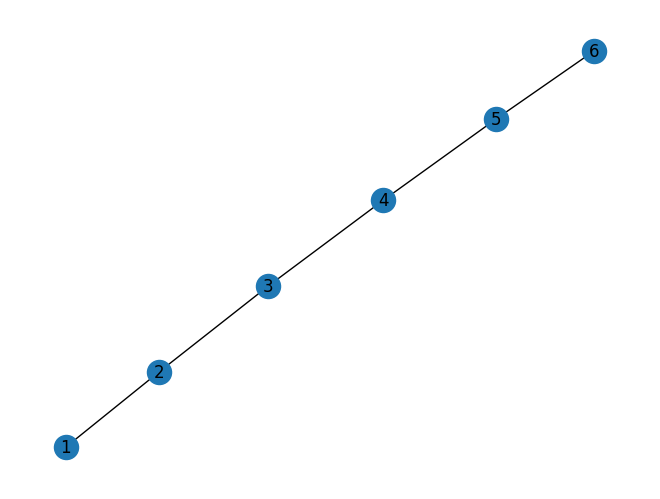

Original: 786432
Tensor Network: 29370
CR: 26.77671092951992
epoch 10/100 err: 0.9934204820362503
epoch 20/100 err: 0.1086000725924875
epoch 30/100 err: 0.10126687755128305
epoch 40/100 err: 0.0998847075121474
epoch 50/100 err: 0.09944420832750726
epoch 60/100 err: 0.09928471282166987
epoch 70/100 err: 0.09920919667733318
epoch 80/100 err: 0.09916447141123688
epoch 90/100 err: 0.0991352814721478
epoch 100/100 err: 0.09911572825416373
time_resh: 11.74835467338562
Time: 13.16s

Rel Error: 0.09911418171585736
{'shape': (3, 16, 8, 16, 8, 16), 'edges': [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)], 'ranks': [9, 9, 9, 9, 9, 9], 'iters': 1000}


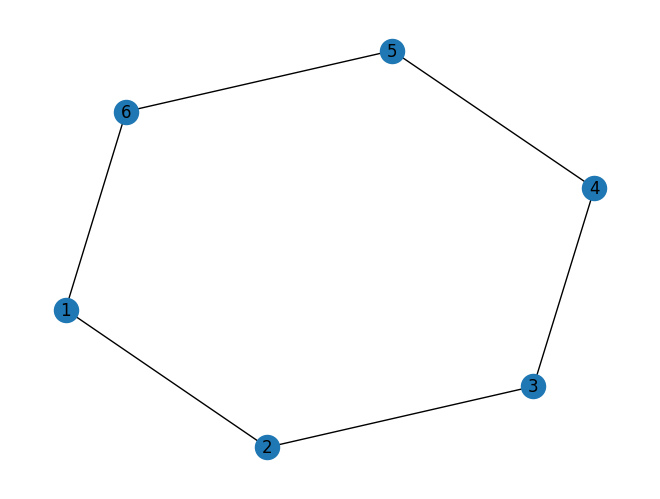

Original: 786432
Tensor Network: 5427
CR: 144.9110005527916
epoch 10/1000 err: 0.13302425674612445
epoch 20/1000 err: 0.12695968163755122
epoch 30/1000 err: 0.12446171141079172
epoch 40/1000 err: 0.12311918404452439
epoch 50/1000 err: 0.12220830406826927
epoch 60/1000 err: 0.12149632135269224
epoch 70/1000 err: 0.1209418368547881
epoch 80/1000 err: 0.12049512820227465
epoch 90/1000 err: 0.12012219486705956
epoch 100/1000 err: 0.11979366816442037
epoch 110/1000 err: 0.11948635779131077
epoch 120/1000 err: 0.11919272534493089
epoch 130/1000 err: 0.1189079913224746
epoch 140/1000 err: 0.11864099974702053
epoch 150/1000 err: 0.11839442403152041
epoch 160/1000 err: 0.11816586276724726
epoch 170/1000 err: 0.11795245602406669
epoch 180/1000 err: 0.11774814199354165
epoch 190/1000 err: 0.11755414858045814
epoch 200/1000 err: 0.11736568851046073
epoch 210/1000 err: 0.11718580045931722
epoch 220/1000 err: 0.1170123083932297
epoch 230/1000 err: 0.11684199489079698
epoch 240/1000 err: 0.1166764064

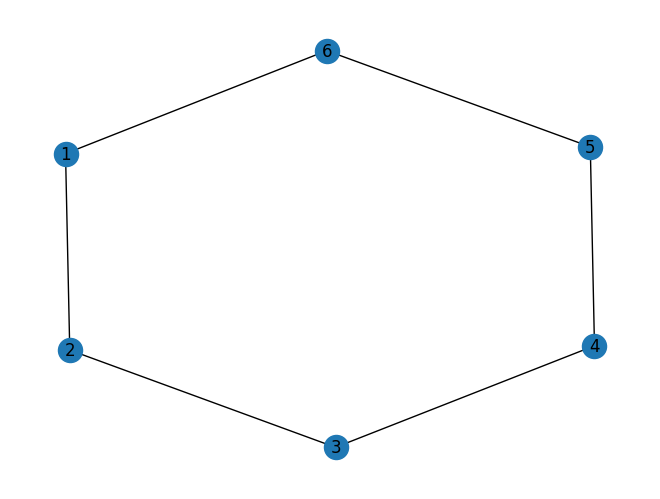

Original: 786432
Tensor Network: 9648
CR: 81.51243781094527
epoch 10/500 err: 0.10967445819400759
epoch 20/500 err: 0.10506193489568001
epoch 30/500 err: 0.10326589099973148
epoch 40/500 err: 0.10212830715948071
epoch 50/500 err: 0.10126205141918126
epoch 60/500 err: 0.10061632116120127
epoch 70/500 err: 0.10015074318704024
epoch 80/500 err: 0.09980055717656257
epoch 90/500 err: 0.09950675375609856
epoch 100/500 err: 0.09924006527106635
epoch 110/500 err: 0.09899262691359635
epoch 120/500 err: 0.09876429879580155
epoch 130/500 err: 0.0985555627537372
epoch 140/500 err: 0.0983635277710718
epoch 150/500 err: 0.09818943729568985
epoch 160/500 err: 0.09803242091407222
epoch 170/500 err: 0.09788996841580201
epoch 180/500 err: 0.09775967062060298
epoch 190/500 err: 0.09763873754228422
epoch 200/500 err: 0.09752600344845402
epoch 210/500 err: 0.09742114970559196
epoch 220/500 err: 0.0973215106722956
epoch 230/500 err: 0.0972281665939146
epoch 240/500 err: 0.09714074443608364
epoch 250/500 err

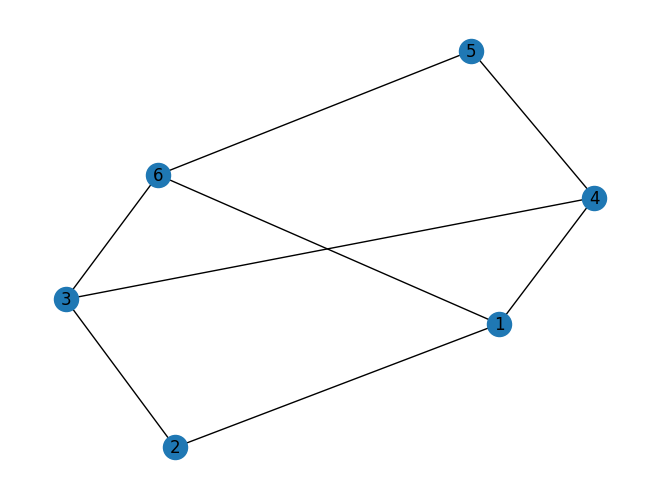

Original: 786432
Tensor Network: 32980
CR: 23.845724681625228
epoch 10/300 err: 0.08963038915753235
epoch 20/300 err: 0.08391632646450649
epoch 30/300 err: 0.0814876162849147
epoch 40/300 err: 0.07994785476951481
epoch 50/300 err: 0.07885708674211618
epoch 60/300 err: 0.07805029112534458
epoch 70/300 err: 0.0774166300833937
epoch 80/300 err: 0.07689782476822597
epoch 90/300 err: 0.0764604497463957
epoch 100/300 err: 0.076088448997094
epoch 110/300 err: 0.0757668156586646
epoch 120/300 err: 0.0754855166609893
epoch 130/300 err: 0.07523837362239186
epoch 140/300 err: 0.07501683783866624
epoch 150/300 err: 0.07482000781009616
epoch 160/300 err: 0.07464207041782149
epoch 170/300 err: 0.07449641604124865
epoch 180/300 err: 0.07435939585592394
epoch 190/300 err: 0.07425486851813155
epoch 200/300 err: 0.07415116496456267
epoch 210/300 err: 0.07409078002667072
epoch 220/300 err: 0.0740701387917877
epoch 230/300 err: 0.07414788537076725
epoch 240/300 err: 0.07450446736630091
epoch 250/300 err: 

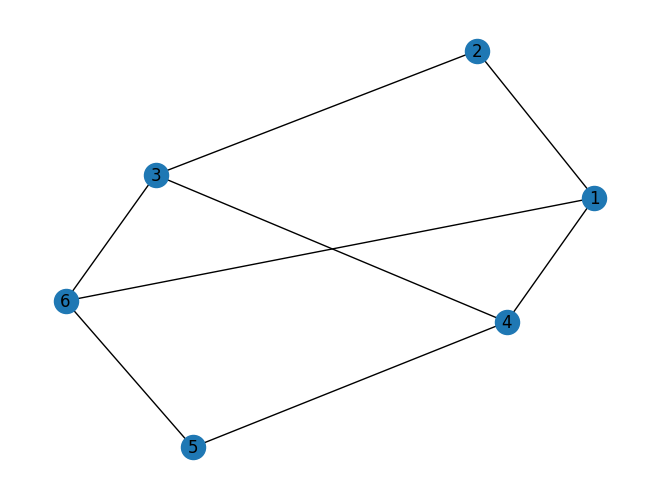

Original: 786432
Tensor Network: 42000
CR: 18.72457142857143
epoch 1/20 err: 14325.35490831468
epoch 2/20 err: 0.1711194898083592
epoch 3/20 err: 0.11274291453863514
epoch 4/20 err: 0.09641063846758975
epoch 5/20 err: 0.09003969334336961
epoch 6/20 err: 0.08671184599848213
epoch 7/20 err: 0.08463137894204843
epoch 8/20 err: 0.08316035678001461
epoch 9/20 err: 0.08203691715945025
epoch 10/20 err: 0.08113405742205028
epoch 11/20 err: 0.08038149944769153
epoch 12/20 err: 0.07973644531449875
epoch 13/20 err: 0.0791731401081638
epoch 14/20 err: 0.07867231038647667
epoch 15/20 err: 0.07822329358382757
epoch 16/20 err: 0.07781513958728348
epoch 17/20 err: 0.07744233836840612
epoch 18/20 err: 0.07709908457988465
epoch 19/20 err: 0.07678208308482509
epoch 20/20 err: 0.07648803097478418
epoch 21/20 err: 0.07621427037990877
time_resh: 143.62883615493774
Time: 146.32s

Rel Error: 0.07621427037990877
{'shape': (3, 16, 8, 16, 8, 16), 'edges': [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1), (3, 6), 

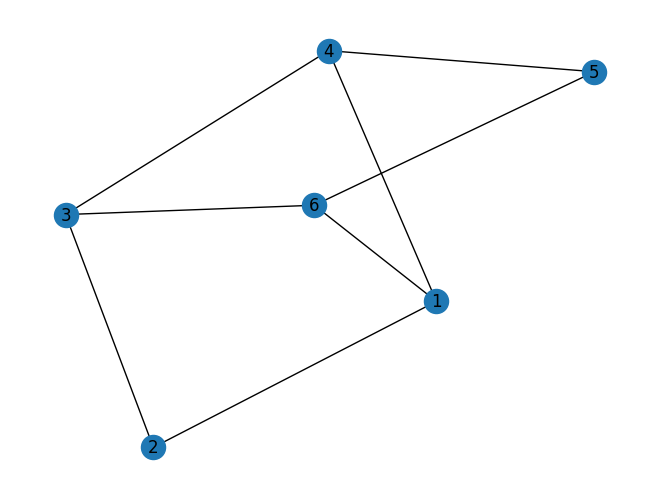

Original: 786432
Tensor Network: 140475
CR: 5.5983769353977575
epoch 1/20 err: 77678.50286188857
epoch 2/20 err: 0.1321422791616351
epoch 3/20 err: 0.07082756865713037
epoch 4/20 err: 0.06155273751579878
epoch 5/20 err: 0.05952669850473527
epoch 6/20 err: 0.18739819659022963
epoch 7/20 err: 1.012796322179585
epoch 8/20 err: 4.9424596356610655
epoch 9/20 err: 0.19721479797484617
epoch 10/20 err: 0.1629971172525969
epoch 11/20 err: 0.0927392109291111
epoch 12/20 err: 0.06875822268771385
epoch 13/20 err: 0.06206858964224077
epoch 14/20 err: 0.05880983914198614
epoch 15/20 err: 0.05667237942892045
epoch 16/20 err: 0.055058974712559924
epoch 17/20 err: 0.053792760074430304
epoch 18/20 err: 0.052754710351560645
epoch 19/20 err: 0.05189097259322735
epoch 20/20 err: 0.05116612796359483
epoch 21/20 err: 0.05057342687211493
time_resh: 1256.9881782531738
Time: 1415.21s

Rel Error: 0.05057342687211493


<Figure size 640x480 with 0 Axes>

In [8]:
# Load image using PIL

# image = Image.open('doradito.png')  # Replace with your image path
# image_shape = (4, 2, 131, 4, 3, 41)

image = Image.open('lenna.png')

data = [
    {
        "shape": (3, 16, 8, 16, 8, 16),
        "edges": [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)],
        "ranks": [30, 20, 30, 20, 30],
        "iters": 100
    },
    {
        "shape": (3, 16, 8, 16, 8, 16),
        "edges": [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)],
        "ranks": [9, 9, 9, 9, 9, 9],
        "iters": 1000
    },
    {
        "shape": (3, 16, 8, 16, 8, 16),
        "edges": [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)],
        "ranks": [12, 12, 12, 12, 12, 12],
        "iters": 500
    },
    {
        "shape": (3, 16, 8, 16, 8, 16),
        "edges": [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1), (3, 6), (1, 4)],
        "ranks": [9, 9, 12, 9, 9, 12, 8, 4],
        "iters": 300
    },
    {
        "shape": (3, 16, 8, 16, 8, 16),
        "edges": [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1), (3, 6), (1, 4)],
        "ranks": [10, 10, 12, 10, 10, 12, 10, 4],
        "iters": 20
    },
    {
        "shape": (3, 16, 8, 16, 8, 16),
        "edges": [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1), (3, 6), (1, 4)],
        "ranks": [15, 15, 17, 15, 15, 17, 15, 8],
        "iters": 20
    }
]

i = 1
for d in data:
    print(d)
    image_shape = d["shape"]
    
    # Define transformation: convert image to tensor
    transform = transforms.ToTensor()
    # device = "cpu"
    
    # Apply transformation
    image_tensor = transform(image)
    
    # Optional: check shape
    # print(image_tensor.shape)  # (C, H, W)
    objective = image_tensor.reshape(image_shape).to(device)
    
    G = nx.Graph()
    G.add_edges_from(d["edges"])
    
    nx.draw(G, with_labels=True)
    plt.savefig("results/graph-" + str(i) + ".png", format="PNG")
    plt.show()
    plt.clf()
    
    
    # If image_tensor is (C, H, W), convert to (H, W, C)
    image_np = image_tensor.permute(1, 2, 0).numpy()
    # Show image
    #plt.imshow(image_np)
    #plt.axis('off')
    #plt.show()
    #plt.clf()
    
    ntn = TN(G, list(objective.shape), d["ranks"])
    
    print("Original: " + str(torch.numel(objective)))
    print("Tensor Network: " + str(ntn.get_tn_size()))
    print("CR: " + str(torch.numel(objective) / ntn.get_tn_size()))
    
    start_time = time.time()
    rel_err = TN.als(ntn, objective, 1e-3, iter_num=d["iters"], print_iters=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time: {elapsed_time:.2f}s" + "\n")
    
    # If image_tensor is (C, H, W), convert to (H, W, C)
    image_np = TN.eval(ntn).reshape(image_tensor.shape).permute(1, 2, 0).cpu().numpy()
    
    # Show image
    norm = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
    plt.imshow(norm)
    plt.imsave("results/lenna-comp" + str(i) + ".png", norm)
    plt.clf()

    print("Rel Error: " + str(rel_err))

    with open("results/data" + str(i) + ".txt", "w") as f:
        f.write("Shape: " + str(d["shape"]) + "\n");
        f.write("Edges: " + str(d["edges"]) + "\n");
        f.write("Ranks: " + str(d["ranks"]) + "\n\n");
        f.write("Original: " + str(torch.numel(objective)) + "\n")
        f.write("Tensor Network: " + str(ntn.get_tn_size()) + "\n")
        f.write("CR: " + str(torch.numel(objective) / ntn.get_tn_size()) + "\n")
        f.write("Rel Error: " + str(rel_err) + "\n")
        f.write("Iters: " + str(d["iters"]) + "\n")
        f.write(f"Time: {elapsed_time:.2f}s" + "\n")


    i += 1